# Load Dependencies

## Install Libraries 

In [63]:
!pip install pandas --break-system-packages
!pip install librosa --break-system-packages
!pip install pyloudnorm --break-system-packages
!pip install tensorflow tensorflow-io --break-system-packages
!pip install pydub --break-system-packages

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 kB 30.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for future: filename=future-0.18.3-py3-none-any.whl size=492025 sha256=ebe7dfd61d8e0bc6bb9c29070dba4e36071f64dab4fc662a378f241faa1f6d36
  Stored in directory: /root/.cache/pip/wheels/da/19/ca/9d8c44cd311a955509d7e13da3f0bea42400c469ef825b580b
Successfully built future


## Import Libaries

In [64]:
import os
import pandas as pd
import math
import numpy as np
from pydub import AudioSegment, silence
import librosa as lb
import pyloudnorm as pyln
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten
import tensorflow_io as tfio

# Data Import

## File Paths

Get positiv and negative files in .wav format

In [3]:
# return list of files for of given folder
def get_files(path: str, file_formats: list, exclude_dirs: list = []):
    filtered_files=[]
    for root, dirs, files in os.walk(path, topdown=True):
        if root not in exclude_dirs:
            for file in files:
                file_name, file_extension = os.path.splitext(file)
                if file_extension in file_formats:
                    file_path = root + "/" + file
                    filtered_files.append(file_path)
    return filtered_files

dir = "/home/helsfyr2_with_9_dbfs/"
neg_dir= "/home/helsfyr2_with_9_dbfs/neg"
file_formats= ['.wav']
pos_files = get_files(dir, file_formats, [neg_dir])
neg_files = get_files(neg_dir, file_formats)
del dir, neg_dir, file_formats

# Data Preperation

## Data pre-processing

In [80]:

file_path = pos_files[0]
y, sr = lb.load(file_path, mono=True)
#Convert to mono
y_mono = lb.to_mono(y=y)

#set sampling rate
target_sr=16000
y_sr = lb.resample(y=y_mono, orig_sr=sr, target_sr=target_sr)

#Normalize loudness
meter = pyln.Meter(rate=target_sr)
loudness = meter.integrated_loudness(data=y_sr)
y_norm = pyln.normalize.loudness(data=y_sr, input_loudness=loudness, target_loudness=-12.0)

/usr/local/lib/python3.11/dist-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")


## Unify audio sequence

### samping rate

### volume

## Audio Slicing

In [70]:


def get_batches(file_path: str, duration: float, offset: float, target_sr: int = 16000):
    y, sr = lb.load(file_path, mono=True)
    duration_total = lb.core.get_duration(y=y, sr=sr)
    Y = []
    for i in range(0, math.floor(duration_total), offset):
        y_orig, sr_orig = lb.load(file_path, mono=True, offset=i, duration=duration)
        y_sample = lb.resample(y=y_orig, orig_sr=sr_orig, target_sr=target_sr)
        Y.append(y_sample)
    return Y, target_sr

file_path = pos_files[0]
audios, sr = get_batches(file_path, duration=2.0, offset=2)

## Mel diagram

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

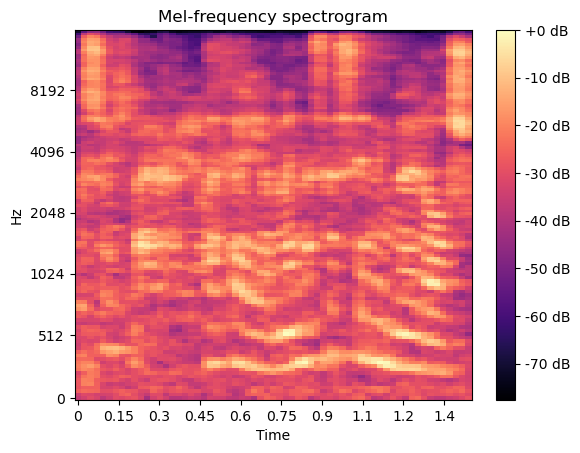

In [83]:
def log_melspectrogram(y: list, sr: int):
    S = lb.feature.melspectrogram(y=y, sr=sr)
    return lb.power_to_db(S=S, ref=np.max)

audio = audios[0]
fig, ax = plt.subplots()
S_dB = log_melspectrogram(y=audio, sr=sr)
img = lb.display.specshow(data=S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=16000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

Average Mel spectogram pos/neg?